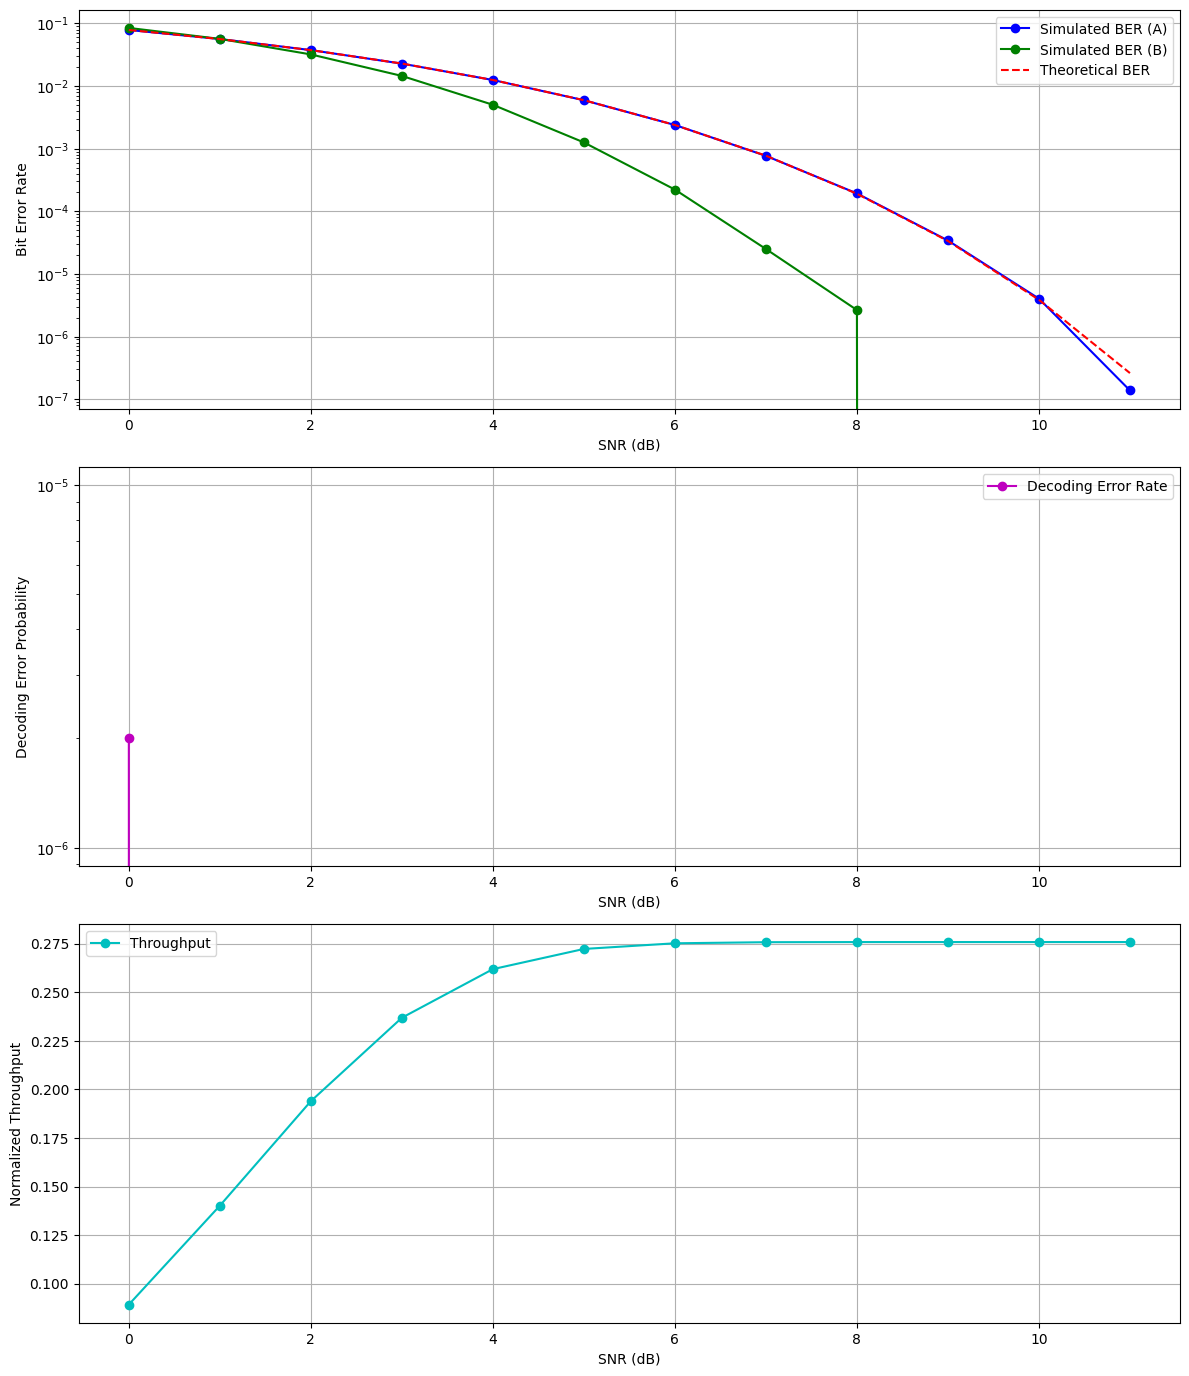

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from numba import njit, prange

# Параметры
l = 8  # Длина сообщения
crc_poly = np.array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], dtype=np.int8)  # CRC-16 полином
N = 1000000  # Уменьшено для ускорения выполнения
SNR_dBs = np.arange(0, 12, 1)

@njit
def compute_crc(data_bits, poly):
    len_poly = len(poly)
    len_data = len(data_bits)
    shifted_data = np.zeros(len_data + len_poly - 1, dtype=np.int8)
    shifted_data[:len_data] = data_bits
    for i in range(len_data):
        if shifted_data[i]:
            shifted_data[i:i+len_poly] ^= poly
    return shifted_data[-len_poly + 1:]

@njit
def bpsk_modulate(bits):
    return 1.0 - 2.0 * bits.astype(np.float64)

@njit
def add_awgn(signal, snr_db):
    snr_linear = 10.0 ** (snr_db / 10.0)
    sigma = np.sqrt(1.0 / (2.0 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal))
    return signal + noise

@njit
def bpsk_demodulate(received_signal):
    return (received_signal < 0).astype(np.int8)

@njit
def check_crc(received_bits, poly):
    len_poly = len(poly)
    data_copy = received_bits.copy()
    for i in range(len(data_copy) - len_poly + 1):
        if data_copy[i]:
            data_copy[i:i+len_poly] ^= poly
    return np.any(data_copy[-len_poly + 1:] != 0)

@njit
def hamming_encode(data):
    n = 31
    parity_positions = np.array([0, 1, 3, 7, 15])
    codeword = np.zeros(n, dtype=np.int8)
    
    info_idx = 0
    for i in range(n):
        if i not in parity_positions:
            codeword[i] = data[info_idx]
            info_idx += 1
    
    for pos in parity_positions:
        parity = 0
        for i in range(n):
            if i != pos and ((i + 1) & (pos + 1)):
                parity ^= codeword[i]
        codeword[pos] = parity
    return codeword

@njit
def hamming_decode(codeword):
    n = 31
    parity_positions = np.array([0, 1, 3, 7, 15])
    syndrome = 0
    
    for j, pos in enumerate(parity_positions):
        parity = 0
        for i in range(n):
            if i != pos and ((i + 1) & (pos + 1)):
                parity ^= codeword[i]
        if parity != codeword[pos]:
            syndrome |= (1 << j)
    
    if syndrome != 0:
        error_pos = syndrome - 1
        if error_pos < n:
            codeword[error_pos] ^= 1
    
    decoded = np.zeros(n - len(parity_positions), dtype=np.int8)
    idx = 0
    for i in range(n):
        if i not in parity_positions:
            decoded[idx] = codeword[i]
            idx += 1
    return decoded

@njit(parallel=True)
def simulate(N, l, crc_poly, SNR_dBs):
    ber_a = np.zeros(len(SNR_dBs))
    ber_b = np.zeros(len(SNR_dBs))
    decoding_error = np.zeros(len(SNR_dBs))
    speed = np.zeros(len(SNR_dBs))
    
    for snr_idx in prange(len(SNR_dBs)):
        snr_db = SNR_dBs[snr_idx]
        total_a = total_b = errors_a = errors_b = 0
        dec_errors = total_transmitted = successful = 0
        
        for _ in range(N):
            # Генерация данных
            data = (np.random.randint(0, 2, l)).astype(np.int8)
            crc = compute_crc(data, crc_poly)
            data_crc = np.concatenate((data, crc))
            data_padded = np.concatenate((data_crc, np.zeros(2, dtype=np.int8)))
            
            # Кодирование Хэмминга
            encoded = hamming_encode(data_padded)
            tx_bits = encoded[:-2]
            
            attempts = 0
            while True:
                attempts += 1
                # Передача
                modulated = bpsk_modulate(tx_bits)
                rx_signal = add_awgn(modulated, snr_db)
                rx_bits = bpsk_demodulate(rx_signal)
                
                # Статистика A'
                errors_a += np.sum(tx_bits != rx_bits)
                total_a += len(tx_bits)
                
                # Добавление нулей
                rx_padded = np.concatenate((rx_bits, np.zeros(2, dtype=np.int8)))
                # Декодирование Хэмминга
                decoded = hamming_decode(rx_padded)
                
                # Статистика B'
                errors_b += np.sum(data_padded != decoded)
                total_b += len(data_padded)
                
                # Проверка CRC
                decoded_data = decoded[:-2]
                if not check_crc(decoded_data, crc_poly):
                    # Проверка данных
                    if not np.array_equal(decoded_data[:l], data):
                        dec_errors += 1
                    successful += l
                    total_transmitted += attempts * len(tx_bits)
                    break
        
        # Расчет метрик
        ber_a[snr_idx] = errors_a / total_a if total_a > 0 else 0
        ber_b[snr_idx] = errors_b / total_b if total_b > 0 else 0
        decoding_error[snr_idx] = dec_errors / N
        speed[snr_idx] = successful / total_transmitted if total_transmitted > 0 else 0
        
    return ber_a, ber_b, decoding_error, speed

# Запуск симуляции
ber_a, ber_b, dec_err, speed = simulate(N, l, crc_poly, SNR_dBs)

# Теоретические значения
theoretical_ber = [0.5 * erfc(np.sqrt(10 ** (snr_db / 10))) for snr_db in SNR_dBs]
# Построение графиков
plt.figure(figsize=(12, 18))

# BER
plt.subplot(4, 1, 1)
plt.semilogy(SNR_dBs, ber_a, 'bo-', label='Simulated BER (A)')
plt.semilogy(SNR_dBs, ber_b, 'go-', label='Simulated BER (B)')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid()
plt.legend()

# Ошибка декодирования
plt.subplot(4, 1, 2)
plt.semilogy(SNR_dBs, dec_err, 'mo-', label='Decoding Error Rate')
plt.xlabel('SNR (dB)')
plt.ylabel('Decoding Error Probability')
plt.grid()
plt.legend()

# Скорость
plt.subplot(4, 1, 3)
plt.plot(SNR_dBs, speed, 'co-', label='Throughput')
plt.xlabel('SNR (dB)')
plt.ylabel('Normalized Throughput')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


0
0
0
0
0
0
0
0
0
0
0
1


C:\Users\Maxim\AppData\Local\Temp\ipykernel_16532\2756213836.py:138: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  A_i = np.math.comb(n, i) / (2 ** r)


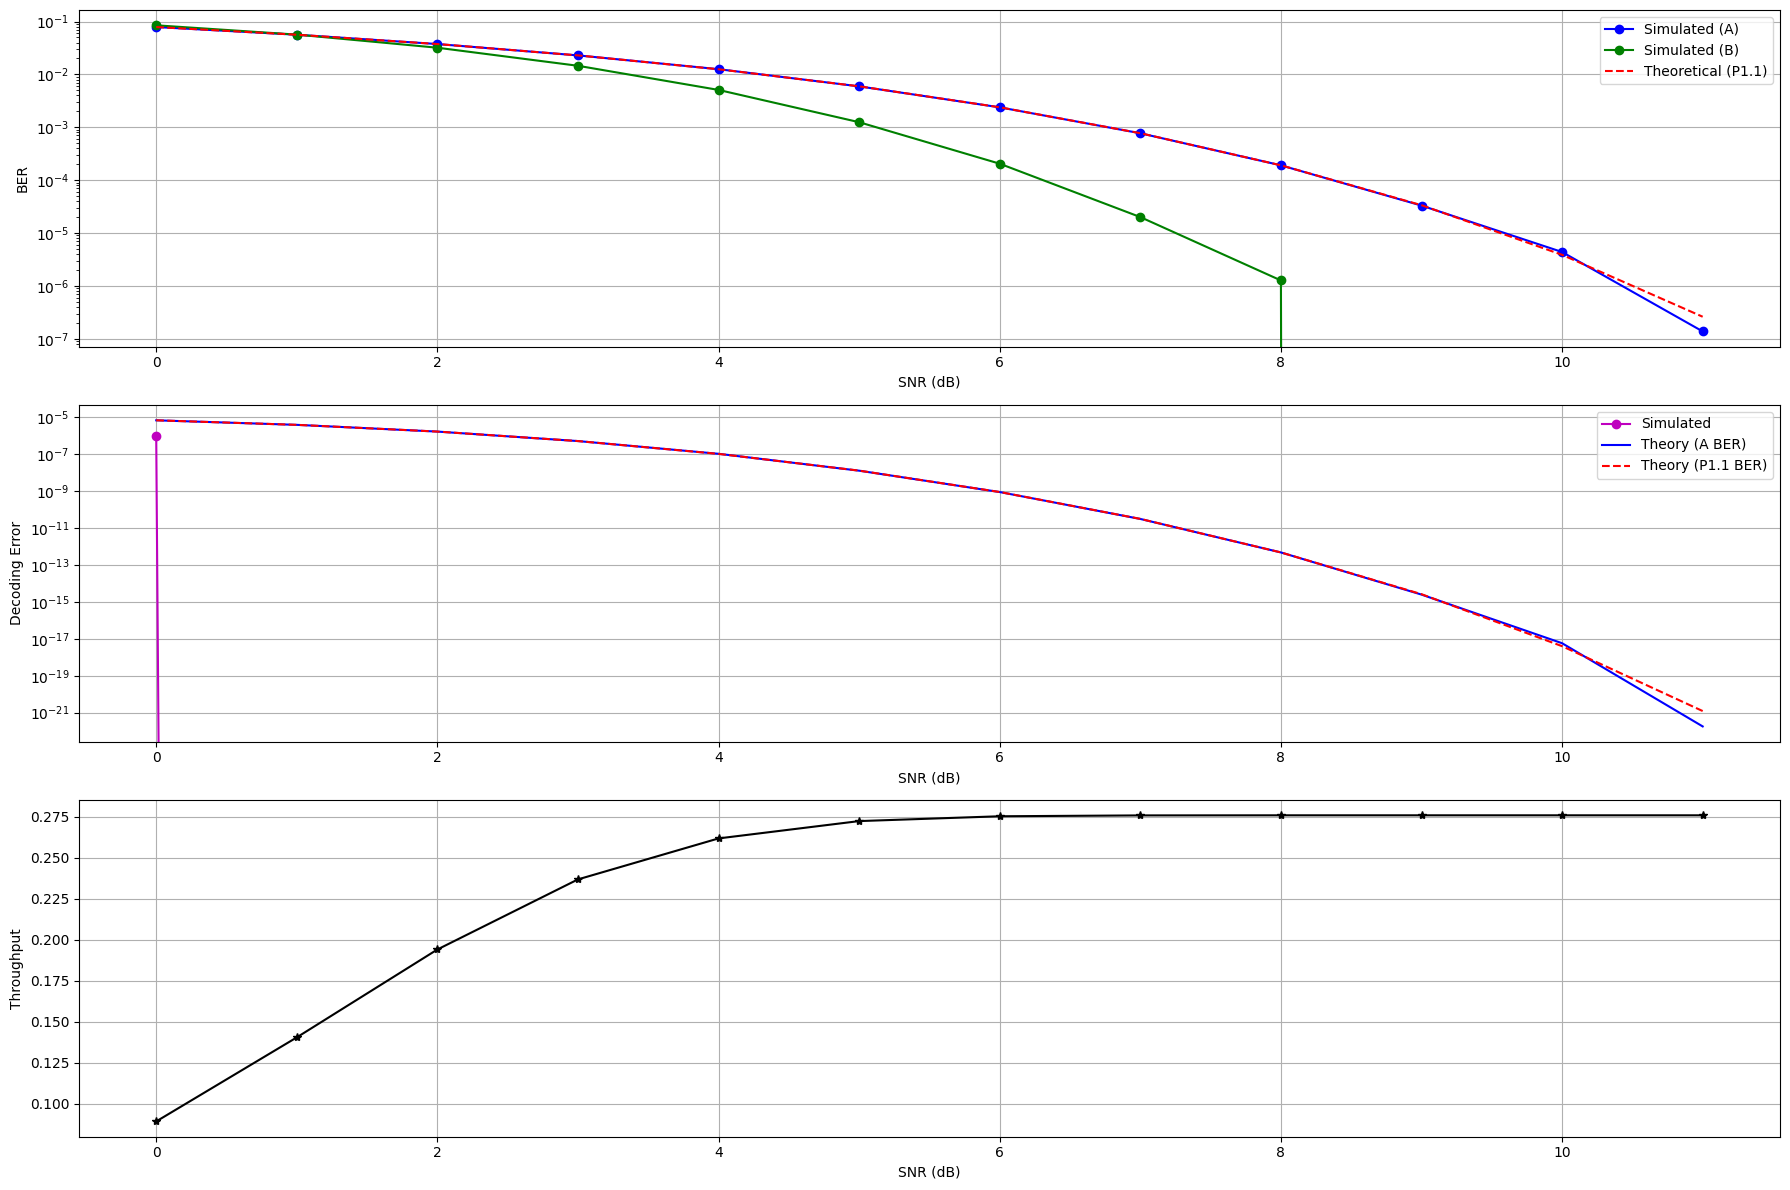

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from numba import njit, prange

l = 8
crc_poly = np.array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], dtype=np.int8)
N = 1000000
SNR_dBs = np.arange(0, 12, 1)
# SNR_dBs = np.arange(0, 21, 1)
n_code = 31
d_min = 3
r_crc = 16

@njit
def compute_crc(data_bits, poly):
    len_poly = len(poly)
    len_data = len(data_bits)
    shifted_data = np.zeros(len_data + len_poly - 1, dtype=np.int8)
    shifted_data[:len_data] = data_bits
    for i in range(len_data):
        if shifted_data[i]:
            shifted_data[i:i+len_poly] ^= poly
    return shifted_data[-len_poly + 1:]

@njit
def check_crc(received_bits, poly):
    len_poly = len(poly)
    data_copy = received_bits.copy()
    for i in range(len(data_copy) - len_poly + 1):
        if data_copy[i]:
            data_copy[i:i+len_poly] ^= poly
    return np.any(data_copy[-len_poly + 1:] != 0)

@njit
def hamming_encode(data):
    n = 31
    parity_positions = np.array([0, 1, 3, 7, 15])
    codeword = np.zeros(n, dtype=np.int8)
    info_idx = 0
    for i in range(n):
        if i not in parity_positions:
            codeword[i] = data[info_idx]
            info_idx += 1
    for pos in parity_positions:
        parity = 0
        for i in range(n):
            if i != pos and ((i + 1) & (pos + 1)):
                parity ^= codeword[i]
        codeword[pos] = parity
    return codeword

@njit
def hamming_decode(codeword):
    n = 31
    parity_positions = np.array([0, 1, 3, 7, 15])
    syndrome = 0
    for j, pos in enumerate(parity_positions):
        parity = 0
        for i in range(n):
            if i != pos and ((i + 1) & (pos + 1)):
                parity ^= codeword[i]
        if parity != codeword[pos]:
            syndrome |= (1 << j)
    if syndrome != 0:
        error_pos = syndrome - 1
        if error_pos < n:
            codeword[error_pos] ^= 1
    decoded = np.zeros(n - len(parity_positions), dtype=np.int8)
    idx = 0
    for i in range(n):
        if i not in parity_positions:
            decoded[idx] = codeword[i]
            idx += 1
    return decoded

@njit(parallel=True)
def simulate(N, l, crc_poly, SNR_dBs):
    ber_a = np.zeros(len(SNR_dBs))
    ber_b = np.zeros(len(SNR_dBs))
    dec_err_sim = np.zeros(len(SNR_dBs))
    speed = np.zeros(len(SNR_dBs))
    
    for snr_idx in prange(len(SNR_dBs)):
        snr_db = SNR_dBs[snr_idx]
        total_a = total_b = errors_a = errors_b = 0
        dec_errors = total_transmitted = 0
        
        for _ in range(N):
            data = (np.random.randint(0, 2, l)).astype(np.int8)
            crc = compute_crc(data, crc_poly)
            data_crc = np.concatenate((data, crc))
            data_padded = np.concatenate((data_crc, np.zeros(2, dtype=np.int8)))
            
            encoded = hamming_encode(data_padded)
            tx_bits = encoded[:-2]
            
            attempts = 0
            while True:
                attempts += 1
                modulated = 1.0 - 2.0 * tx_bits.astype(np.float64)
                noise = np.random.normal(0, np.sqrt(0.5 / (10 ** (snr_db / 10))), len(modulated))
                rx_signal = modulated + noise
                rx_bits = (rx_signal < 0).astype(np.int8)
                
                errors_a += np.sum(tx_bits != rx_bits)
                total_a += len(tx_bits)
                
                rx_padded = np.concatenate((rx_bits, np.zeros(2, dtype=np.int8)))
                decoded = hamming_decode(rx_padded)
                
                errors_b += np.sum(data_padded != decoded)
                total_b += len(data_padded)
                
                decoded_data = decoded[:-2]
                if not check_crc(decoded_data, crc_poly):
                    if not np.array_equal(decoded_data[:l], data):
                        dec_errors += 1
                    total_transmitted += attempts * len(tx_bits)
                    break
        
        ber_a[snr_idx] = errors_a / total_a
        ber_b[snr_idx] = errors_b / total_b
        dec_err_sim[snr_idx] = dec_errors / N
        print(dec_errors)
        speed[snr_idx] = (l * N) / total_transmitted if total_transmitted > 0 else 0
    
    return ber_a, ber_b, dec_err_sim, speed

def theoretical_ber_func(snr_db):
    return 0.5 * erfc(np.sqrt(10 ** (snr_db / 10)))

def theoretical_decoding_error(p, n, d, r):
    Pe = 0.0
    for i in range(d, n+1):
        A_i = np.math.comb(n, i) / (2 ** r)
        Pe += A_i * (p ** i) * ((1 - p) ** (n - i))
    return Pe

ber_a, ber_b, dec_err_sim, speed = simulate(N, l, crc_poly, SNR_dBs)
theoretical_ber = [theoretical_ber_func(snr) for snr in SNR_dBs]
dec_err_theory_a = [theoretical_decoding_error(ber_a[i], n_code, d_min, r_crc) for i in range(len(SNR_dBs))]
dec_err_theory_p1 = [theoretical_decoding_error(theoretical_ber[i], n_code, d_min, r_crc) for i in range(len(SNR_dBs))]

plt.figure(figsize=(18, 12))

# График 1: BER
plt.subplot(3, 1, 1)
plt.semilogy(SNR_dBs, ber_a, 'bo-', label='Simulated (A)')
plt.semilogy(SNR_dBs, ber_b, 'go-', label='Simulated (B)')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical (P1.1)')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid()
plt.legend()

# График 2: Ошибки декодирования
plt.subplot(3, 1, 2)
plt.semilogy(SNR_dBs, dec_err_sim, 'mo-', label='Simulated')
plt.semilogy(SNR_dBs, dec_err_theory_a, 'b-', label='Theory (A BER)')
plt.semilogy(SNR_dBs, dec_err_theory_p1, 'r--', label='Theory (P1.1 BER)')
plt.xlabel('SNR (dB)')
plt.ylabel('Decoding Error')
plt.grid()
plt.legend()

# График 3: Скорость
plt.subplot(3, 1, 3)
plt.plot(SNR_dBs, speed, 'k*-')
plt.xlabel('SNR (dB)')
plt.ylabel('Throughput')
plt.grid()
plt.tight_layout()
plt.show()